In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno 
from pytz import timezone
import re
import pytz

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


From these we can see that 4 datetime columns are strings instead of datetime objects

In [4]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


<AxesSubplot:>

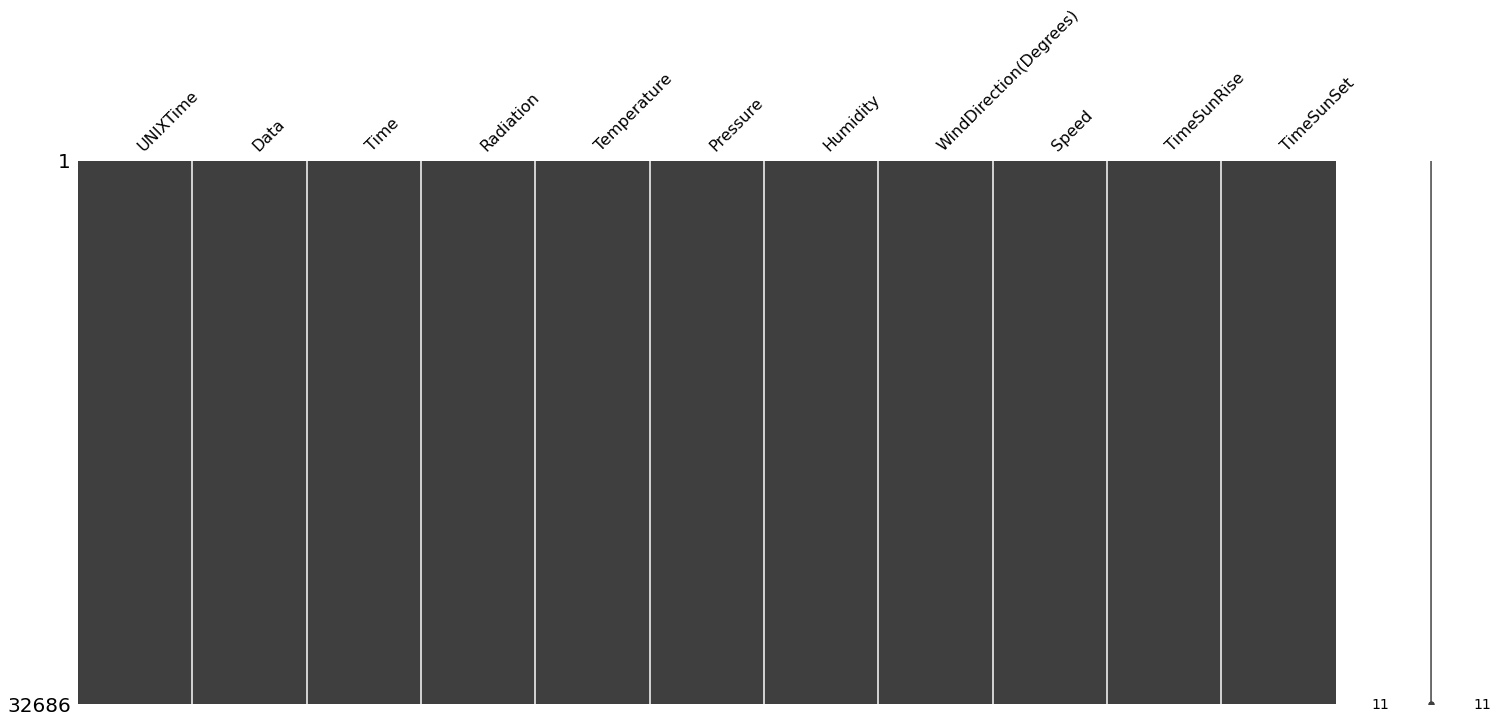

In [5]:
missingno.matrix(df)

In [6]:
def preprocess_data(df):

    """
    Description:
        Convert timezone to Hawaii
        Rename some of the columns
        Convert string columns to datetime objects
        add new feature from TimeSunSet and TimeSunRise columns
    
    Args:
        val: input df (DataFrame)
        
    Returns:
        df -> preprocessed DataFrame
    """

    # 'Data' - all elements contain the same value.
    # we have UNIXTime so we can drop Time.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # index by UNIX time
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime
    
     # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii= timezone('Pacific/Honolulu')
    df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    #rename some of the columns
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    #convert string columns to datetime objects
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour 
    df['Date'] = df.index.date

    #extract sunrise and sunrise hour and minute
    df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df.drop(['TimeSunRise', 'TimeSunSet'],axis=1,inplace = True)



    
    
    return df

In [7]:
df = preprocess_data(df)
df.head()

<ipython-input-6-ab4333ecb863>:35: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.week


,Radiation,Temperature,Pressure,Humidity,WindDirection,WindSpeed,day_of_month,week_of_year,month,hour,Date,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
UNIXTime,,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25,1,35,9,0,2016-09-01,6,7,18,38
